**Ejercicio 1:** Implemente las estructuras de datos y algoritmos básicos para la solución de un problema mediante algoritmos genéticos. Pruebe estas rutinas y compare los resultados con un método de gradiente descendiente para buscar el mínimo global de distintas funciones.

#### **Librerías**

In [109]:
from matplotlib import pyplot as plt
import numpy as np
import random
import time

<h4><b>Algoritmo</b></h2>


En un principio, ya que vamos a trabajar tanto con números binarios como decimales vamos a necesitar una función que se encargue de la decodificación.
Como regla general, vamos a tomar el primer bit de la cadena como el bit de signo y los 4 últimos bits de la cadena como decimales. Los bits en el medio serán los bits de enteros y serán variables según el problema.

In [110]:
def decodif(poblacion):     # Pasa la población del genotipo (binario) al fenotipo (decimal)
    poblacion_dec = []
    for genotipo in poblacion:
        decimal = int(genotipo[1:-4], 2) + 0.1*int(genotipo[-4:],2)   # Convierte la cadena binaria a un entero
        if genotipo[0] == '1':
            poblacion_dec.append(-decimal)
        else:
            poblacion_dec.append(decimal)
    return poblacion_dec

Recordamos el diagrama de flujo de nuestro algoritmo:
<br><br>
<img src="data/diagflujo.png" width="200">

En cuanto a los operadores de selección, tenemos varias opciones para utilizar, cada una con sus ventajas y desventajas, y que programamos para poder elegir a la hora de correr el algoritmo:
- **Rueda de ruleta:** Tengo una ruleta con todos los individuos de la población, tal que aquellos con más aptitud tienen más probabilidad de salir sorteados si giro la ruleta.
- **Método de ventanas:** Ordena los individuos de mayor fitness a menor fitness y va tomando ventanas empezando de arriba. Vamos haciendo ventanas cada vez más chicas.
- **Competencias:** Elijo k individuos al azar, los hago copmetir y el mayor gana. Con varias etapas, simulamos un torneo entre los individuos de la población.

In [111]:
def ruleta(poblacion, aptitudes):
    suma = sum(aptitudes)
    probabilidades = [apt/suma for apt in aptitudes]
    acumulador = 0
    ruleta = []
    for probabilidad in probabilidades:
        acumulador += probabilidad
        ruleta.append(acumulador)
    p = random.random()
    for i, probabilidad in enumerate(ruleta):
        if p <= probabilidad:
            ganador = i
    return poblacion[ganador]

def competencias(poblacion,aptitudes,k=2):
    competidores = np.random.randint(0,len(aptitudes),(k,1))
    ganador = np.argmax(aptitudes[competidores])
    return poblacion[ganador]

def ventanas(poblacion,aptitudes):
    poblacion_seleccionada = [];
    aptitudes = np.array(aptitudes);
    ventana = np.argsort(aptitudes);
    ventana - ventana[::-1];
    for i in range(ventana.shape[0]):
        poblacion_seleccionada.append(np.random.choice(ventana));
        ventana = ventana[:-1]; #elimino el ultimo elemento de la ventana
    seleccion = np.argmax(aptitudes[poblacion_seleccionada])
    return poblacion[poblacion_seleccionada[seleccion]]

Luego tenemos los operadores de variación: la mutación y la cruza. Para esto generamos funciones auxiliares de la misma manera.

In [112]:
def cruza(padre,madre,prob):
    prob_i = np.random.rand()
    if prob_i < prob:
        punto_corte = random.randint(1,len(padre))
        hijo1 = padre[:punto_corte] + madre[punto_corte:]
        hijo2 = madre[:punto_corte] + padre[punto_corte:]
    else:
        hijo1 = padre
        hijo2 = madre
    return hijo1,hijo2

def mutacion(individuo,prob):   # Le paso probabilidad a nivel de individuo
    prob_i = np.random.rand()
    if prob_i < prob:
        pos = np.random.choice(len(individuo))
        individuo_aux = list(individuo)
        if(individuo_aux[pos] == '0'):
            individuo_aux[pos] = '1'
        else:
            individuo_aux[pos] = '0'

        individuo = ''.join(individuo_aux) 
    return individuo

Definimos un operador de reemplazo para el algoritmo. En particular, vamos a utilizar el elitismo: el individuo más apto pasa a la nueva generación sin ser cruzado o mutado.

In [113]:
def elitismo(poblacion,aptitudes):
    apt_aux = list(enumerate(aptitudes))
    ordenados = sorted(apt_aux,key=lambda x: x[1], reverse=True)
    idx = ordenados[0][0]  # Mayor aptitud
    return poblacion[idx]  

La función general *algoritmo_genetico* va a recibir varios argumentos:
- **size_p:** Tamaño de la población o cantidad de individuos.
- **bits:** Longitud del cromosoma o número de bits para cada individuo de la población.
- **max_gen:** Número máximo de generaciones.
- **max_estable:** Cantidad de iteraciones para considerar una solución estable con elitismo.
- **func_seleccion:** Función para seleccionar un individuo de la población.
- **func_aptitud:** Función para calcular aptitud de la población.
- **prob_mutacion:** Probabilidad asociada a la mutación.
- **prob_cruza:** Probabilidad asociada a la cruza.

In [114]:
def algoritmo_genetico(size_p,bits,max_gen,max_estable,func_seleccion,func_aptitud,prob_mutacion,prob_cruza):
    
    inicio = time.time()

    # PASO 1: Inicialización de la población
    poblacion = [''.join(random.choices('01',k=bits-1)) for _ in range(size_p)]
    for individuo in poblacion:
        if int(individuo[-4],2) > 9:
            individuo = individuo[:-4] + '1001' # Que no pase de 9 la parte decimal
    cont_estabilidad = 0;
    apt_max = 1e-6;
    aptitudes_max = []

    for gen in range(max_gen):
        poblacion_dec = decodif(poblacion)                                  # Decodifico para pasarselo a la función de aptitud
        aptitudes = func_aptitud(poblacion_dec)   # Obtengo aptitudes
        nueva_pob = []

        # Elitismo
        mejor = elitismo(poblacion,aptitudes)
        nueva_pob.append(mejor)
        
        while(len(nueva_pob) < len(poblacion)):
            # PASO 2: Selección (elegimos uno de los métodos propuestos en funciones auxiliares):
            padre = func_seleccion(poblacion,aptitudes)
            madre = func_seleccion(poblacion,aptitudes)

            # PASO 3: CRUZA (me va a devolver los hijos cruzados o los padres, depende probabilidad)
            hijo1, hijo2 = cruza(padre,madre,prob_cruza)               
            # PASO 4: MUTACION (me va a devolver hijos mutados o no, depende probabilidad)  
            hijo1 = mutacion(hijo1,prob_mutacion)   
            hijo2 = mutacion(hijo2,prob_mutacion)
            # Los agrego a la nueva generación      
            nueva_pob.append(hijo1)
            nueva_pob.append(hijo2)

        # PASO 5: EVALUACIÓN (vemos si se estabilizó por elitismo) --> puede estar arriba despues de calcular aptitudes
        if(np.isclose(max(aptitudes),apt_max)):
            cont_estabilidad += 1
        else:
            cont_estabilidad = 0
        if(cont_estabilidad >= max_estable):
            break

        poblacion = nueva_pob
        aptitudes_max.append(max(aptitudes))
        apt_max = max(aptitudes)

    poblacion_dec = decodif(poblacion)
    apt_aux = list(enumerate(aptitudes))
    ordenados = sorted(apt_aux,key=lambda x: x[1], reverse=True)
    idx = ordenados[0][0]
    
    # Grafico elite
    plt.plot(range(gen),aptitudes_max)
    
    
    fin = time.time()
    print(f'El algoritmo terminó en la generación {gen} en {round(fin-inicio,4)} segundos.')

    return poblacion[idx]

#### **Prueba**
Con el método del gradiente, realizamos una comparación entre los resultados que éste y nuestro algoritmo genético arrojan para las funciones propuestas. Como buscamos el mínimo de las funciones, queremos minimizar la función de aptitud y para eso multiplicamos nuestra función objetivo f1 por -1.

**Función 1:** $ f(x) = - x \sin(\sqrt{|x|}) $, con $ x \in [-512...512] $

El mínimo de la función está en (418.909090909091,-418.4481325008988)


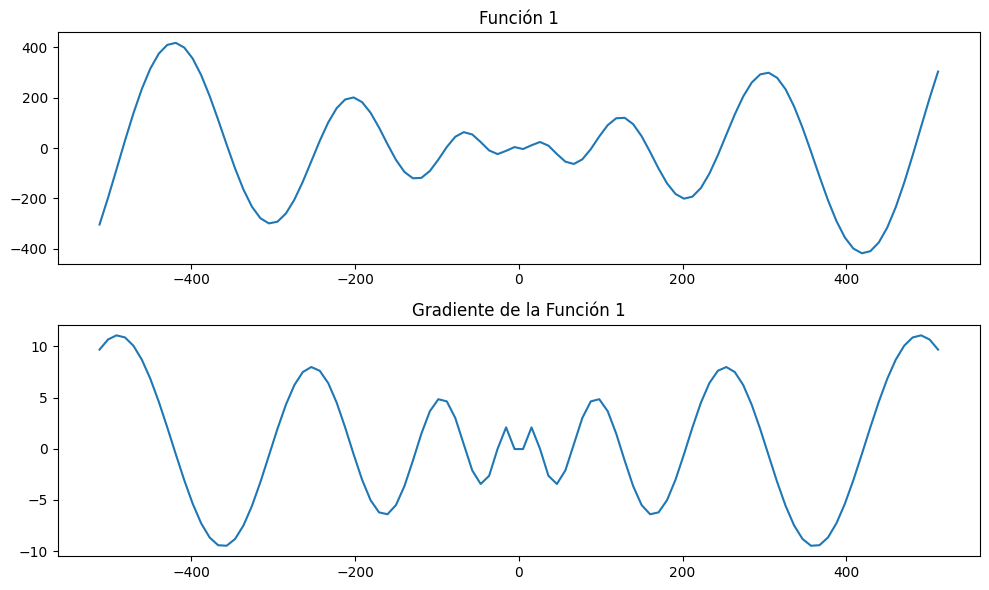

In [115]:
def f1(x):
    return -x*np.sin(np.sqrt(abs(x)))
def grad_f1(x):
    return -np.sin(np.sqrt(abs(x))) - (x**2 * np.cos(np.sqrt(abs(x))))/(2*abs(x)*np.sqrt(abs(x)))

x = np.linspace(-512,512,100)
y_f1 = f1(x)
y_grad_f1 = grad_f1(x)

fig,(ax1,ax2) = plt.subplots(2,1,figsize=(10,6))
ax1.plot(x,y_f1)
ax1.set_title('Función 1')
ax2.plot(x,y_grad_f1)
ax2.set_title('Gradiente de la Función 1')
plt.tight_layout()

print(f'El mínimo de la función está en ({x[np.argmin(y_f1)]},{np.min(y_f1)})')

# grafica de los individuos por generación para ver cómo se van moviendo por generación

- Mínimo mediante el algoritmo genético: Usamos 1 bit de signo, 9 bits para la parte entera del número (ya que 2^9 = 512) y 4 bits para la parte decimal. Luego, seteamos bits = 1 + 9 + 4 = 15

El algoritmo terminó en la generación 33 en 0.0207 segundos.
Mínimo encontrado en ( 420.5 , -418.9551671367161 )


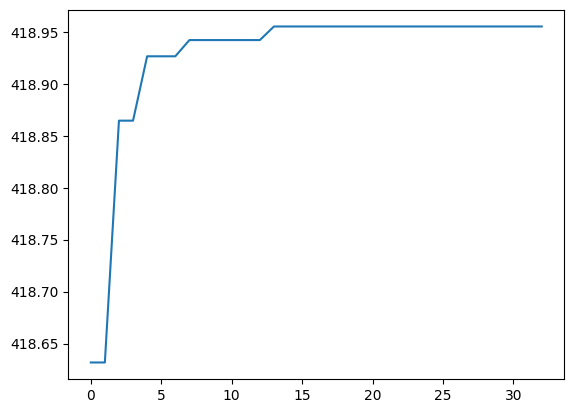

In [116]:
def func_aptitud(pob):
    pob = np.array(pob)
    return pob*np.sin(np.sqrt(abs(pob)))    # -f1 para obtener la aptitud mínima en vez de máxima

size_p = 15
bits = 15
max_gen = 1000
max_estable = 20
prob_mutacion = 0.1
func_seleccion = competencias
prob_cruza = 0.9
ganador = algoritmo_genetico(size_p,bits,max_gen,max_estable,func_seleccion,func_aptitud,prob_mutacion,prob_cruza)

ganador_dec = decodif([ganador])
print('Mínimo encontrado en (',ganador_dec[0],',',f1(ganador_dec[0]),')')
# para visualizar mejor los resultados y el desempeño del algoritmo, se puede agregar plot del fitness del peor y el fitness promedio
# si la grafica se achica o compacta muy rapido (fitness del mejor y fitness del peor se acercan muy rapido) entonces tengo que dar mas
# variabilidad al algoritmo y cambiar los argumentos (mas size_p, mas probabilidad de cruza, etc)
# si corre y no se acercan entonces reduzco la variabilidad 

- Mínimo mediante método de gradiente descendiente:

In [117]:
lr = 0.01
it = 1000
x = np.random.randint(-512,512)
for i in range(x):
    x = x - lr*grad_f1(x)    # Me muevo en dirección opuesta al gradiente
print('Mínimo encontrado en (',x,',',f1(x),')')

Mínimo encontrado en ( -508 , -264.5312547142381 )
